##  Prediction of Car Prices

###  Objective

The project objective is to develop a predictive model that can accurately estimate car prices in England by leveraging on historical data (provided by Auto Trader) on car attributes, such as make, model, year, mileage, condition, and other relevant factors, to build a model capable of predicting the prices of cars in the market. 

By addressing this problem, the aim is to provide valuable insights and assistance to car buyers, sellers, and market participants in making informed decisions regarding car purchases, valuations, and negotiations in the dynamic automotive market in England.


### Project Approach
Data Preprocessing: Clean and preprocess the data, identify and deal missing values using pipelines and simple Imputer, outliers, noises to ensure data quality and reliability.

#### Feature Engineering and selection: 
Engineered new features from the existing ones, including computing car age, grouping infrequent values of categrorical features, Clusters, and polynomial features to second degree. 
In addition to this, used KBest to automatically select features as part of our predictors and recursively eliminated least important features using RFECV

#### Model Selection and Training: 
The data was divided into training and testing sets to evaluate the models effectively. Various machine learning algorithms suitable for regression tasks, including linear regression, random forests, gradient boosting, and ridge regression, were explored. A grid search technique was employed to identify the best parameters for each model, optimizing their performance. 

The selected models were respectively trained on the training data, and hyperparameters were fine-tuned to enhance performance, utilizing techniques like cross-validation to prevent overfitting. 
Additionally, an ensemble model was implemented to combine the predictions from all the models used, leveraging their collective insights and improving the overall predictive power.

#### Model Evaluation: 
The trained model was evaluated using the testing data to measure its accuracy in predicting car prices. Various evaluation metrics were computed, and the results were compared by visualizing them through dataframes and plots.  The true values were compared to the predicted values using the ensemble model, which incorporated all four models and an averager. Furthermore, global and local explanations of SHAP values were computed to understand their impact on the predicted values. 

Partial Dependence Plots (PDPS) were also utilized to analyze the relationship between individual features and the predicted car prices. Overall, these analyses provided insights into the model's performance, the importance of different features, and the factors influencing the predicted car prices.

Comparing all models, GRadiest Boosting regressor was the best performing model with the least Mean Absolute Error and Root Mean Squared Error



In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%config InlineBackend.figure_format = 'retina'
# https://seaborn.pydata.org/tutorial/aesthetics.html
sns.set(
    style='ticks', 
    context='talk', 
    font_scale=0.8, 
    rc={'figure.figsize': (6,4)}
)

In [2]:
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import MinMaxScaler, StandardScaler, OneHotEncoder

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.model_selection import GridSearchCV, ParameterGrid

from sklearn.dummy import DummyRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet

from statsmodels.formula.api import ols

from sklearn.metrics import mean_squared_error
from functools import partial
rmse = partial(mean_squared_error, squared=False)
from sklearn.feature_selection import SelectKBest, f_regression

from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import VotingRegressor

from sklearn.linear_model import Ridge
from sklearn.dummy import DummyRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import HistGradientBoostingRegressor

from sklearn.pipeline import Pipeline
from sklearn.linear_model import Ridge, Lasso
from sklearn.model_selection import GridSearchCV

In [3]:
from statsmodels.formula.api import ols

from sklearn.metrics import mean_squared_error
from functools import partial
rmse = partial(mean_squared_error, squared=False)
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

In [4]:
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

In [135]:
!pip install -q shap
import shap
shap.initjs()

### 1.0 Data Processing For Machine Learning

In [6]:
cars = pd.read_csv(r'C:\Users\USER\OneDrive\Desktop\car_adverts.csv')

In [ ]:
cars.info()

In [ ]:
# View first five records of the dataset

cars.head()

In [ ]:
# View quick description of numerical values in the dataset

cars.describe()

In [ ]:
# Check for missing values 

cars.isna().sum().sort_values(ascending = False)

In [ ]:
# Check percentage of missing data values for each column 

missing_val_percentage = (round(cars.isna().sum() / len(cars) * 100, 2)
                        .sort_values(ascending = False))
print(missing_val_percentage)

### 1.1 Deal with Missing Values

In [7]:
# Fill missing values of Registration Year For New Cars

current_year = 2023

new_cars = cars.loc[(cars['vehicle_condition'] == 'NEW') 
                   & (cars['year_of_registration'].isna())]

new_cars.loc[:, 'year_of_registration'] = current_year

cars.update(new_cars)


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [8]:
# Fill Missing values of Registration Codes For New Cars

current_regcode = 23

new_reg = cars.loc[(cars['vehicle_condition'] == 'NEW') 
                   & (cars['reg_code'].isna())]

new_reg.loc[:, 'reg_code'] = current_regcode

cars.update(new_reg)


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [9]:
# Fill missing values of registration year for Used Cars with the Median 

cars['year_of_registration'] = (cars['year_of_registration'].
                            fillna(cars['year_of_registration'].median()))

In [10]:
# cars['year_of_registration'] = cars['year_of_registration'].replace(noise_year, 2017)
# Replace years less than or equal to 1900 with 2017

median_year = cars['year_of_registration'].median()
median_year
cars.loc[cars['year_of_registration'] <= 1900, 'year_of_registration'] = median_year

In [11]:
# Group by registration year & fill missing mileage with mean mileage value for the year

cars['mileage'] = cars.groupby('year_of_registration')['mileage'].transform(
    lambda x: x.fillna(x.mean())
)

In [12]:
# Mapping of Registration codes using The "Prefix letter series 1983–2001"

map_reg_codes = {
    'A': 1983, 'B': 1984, 'C': 1985, 'D': 1986, 'E': 1987, 'F': 1988, 'G': 1989, 
    'H': 1990, 'J': 1991, 'K': 1992, 'L': 1993, 'M': 1994, 'N': 1995, 'P': 1996, 
    'R': 1997, 'S': 1998, 'T': 1999, 'V': 1999, 'W': 2000, 'X': 2000, 'Y': 2001
}

missing_years = cars[cars['year_of_registration'].isnull() & cars['reg_code'].isin(map_reg_codes.keys())]

missing_years['year_of_registration'] = missing_years['reg_code'].map(map_reg_codes)

In [13]:
#Update names of columns to make it more user friendly and shorter

cars = cars.rename(columns={
    'public_reference': 'reference',
    'standard_colour': 'colour',
    'standard_make': 'make',
    'standard_model': 'model',
    'vehicle_condition': 'condition',
    'year_of_registration': 'reg_year',
    'body_type': 'body',
    'crossover_car_and_van': 'is_crossover',
    'fuel_type': 'fuel'
})

In [14]:
# FIll missing values of Categorical Features using Pipeline and Simple Imputer

cat_features = ["colour","reg_code","body","fuel"]
cat_transformer = Pipeline (
    steps=[
        ("imputer", SimpleImputer(strategy="most_frequent")), 
            ]
)
cat_transformer

p_processor = ColumnTransformer(
    transformers=[
        ("cat", cat_transformer, cat_features),
    ],
    remainder='passthrough',
    verbose_feature_names_out = False
).set_output(transform = "pandas")
p_processor

ColumnTransformer(remainder='passthrough',
                  transformers=[('cat',
                                 Pipeline(steps=[('imputer',
                                                  SimpleImputer(strategy='most_frequent'))]),
                                 ['colour', 'reg_code', 'body', 'fuel'])],
                  verbose_feature_names_out=False)

In [15]:
cars = p_processor.fit_transform(cars)

In [ ]:
sns.distplot(np.log(cars['price']))
plt.show()

In [ ]:
# Feature correlation using heatmap

sns.heatmap(cars.corr(), annot=True)
plt.show()

In [ ]:
car.describe()

# FEATURE ENGINEERING

In [16]:
# Take a copy of the existing dataset

car = cars.copy()

### 2.1 Computation of Car Age

In [17]:
# Create a new feature to compute the age of the car using the year of registration 

car['car_age'] = (2023 - (car['reg_year']))

### 2.1 Group Infrequent Values of Categorical Features

In [18]:
def group_by_frequency(car, cols, frequency=70000, new_label='Others'):
    for col in cols:
        col_counts = car[col].value_counts()
        col_mapping = {value: new_label if count < frequency 
                       else value for value, 
                       count in col_counts.items()}
        car[col] = car[col].replace(col_mapping)
    return car

In [19]:
cols_to_group = ['body', 'fuel', 'colour']
car = group_by_frequency(car, cols_to_group, frequency=70000, new_label='Others')

In [ ]:
car['colour'].unique()

### 2.3 Target encoding of car make and model

In [20]:
car["make"] = car.groupby("make")["price"].transform("mean")

In [21]:
car["model"] = car.groupby("model")["price"].transform("mean")

In [ ]:
# Feature correlation using heatmap

sns.heatmap(car.corr(), annot=True)
plt.show()

### 2.4 Mileage Cluster using K-Means 

In [22]:
from sklearn.cluster import KMeans

# Assume your data is stored in a DataFrame called 'df' with features 'age', 'mileage', and 'price'

# Create a new DataFrame with just the relevant features
mileage_cluster = car[['mileage']]

# Fit a k-means clustering model with k=3
kmeans = KMeans(n_clusters=4, random_state=42)
kmeans.fit(mileage_cluster)

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning


KMeans(n_clusters=4, random_state=42)

In [23]:
# Extract the cluster assignments for each data point
clusters = kmeans.predict(mileage_cluster)

In [25]:
# Add a new feature to the original DataFrame with the cluster assignments
car['mileage_cluster'] = clusters

In [ ]:
car.head(2)

In [ ]:
# Plot the data points colored by their cluster assignments
plt.scatter(car['mileage'], car['price'], c=car['mileage_cluster'])
plt.xlabel('Mileage')
plt.ylabel('Price')
plt.show()

### 2.5 Polynomial Features

In [26]:
from sklearn.preprocessing import PolynomialFeatures

In [27]:
X, y = car.drop(columns=['price','reg_code','reference','is_crossover', 'reg_year']), car['price']

In [ ]:
X.info()

In [28]:
cate_features = ["colour","body","fuel","condition"]
cate_transformer = Pipeline (
    steps=[
        ("ohe", OneHotEncoder(handle_unknown="ignore", sparse_output=False, drop='if_binary')), 
            ]
).set_output(transform='pandas')

cate_transformer

numeric_features = X.select_dtypes(exclude='object').columns.tolist()
numeric_transformer = Pipeline(
    steps=[
        ("scaler", StandardScaler()),
        ('poly', PolynomialFeatures(2, include_bias=False))
         ]
    ).set_output(transform='pandas')

preprocessor = ColumnTransformer(
    transformers=[
        ("cat", cate_transformer, cate_features),
        ("num", numeric_transformer, numeric_features)
    ],
    remainder='passthrough',
    verbose_feature_names_out = False
).set_output(transform = "pandas")

preprocessor

ColumnTransformer(remainder='passthrough',
                  transformers=[('cat',
                                 Pipeline(steps=[('ohe',
                                                  OneHotEncoder(drop='if_binary',
                                                                handle_unknown='ignore',
                                                                sparse_output=False))]),
                                 ['colour', 'body', 'fuel', 'condition']),
                                ('num',
                                 Pipeline(steps=[('scaler', StandardScaler()),
                                                 ('poly',
                                                  PolynomialFeatures(include_bias=False))]),
                                 ['mileage', 'make', 'model', 'car_age',
                                  'mileage_cluster'])],
                  verbose_feature_names_out=False)

In [29]:
X_new = preprocessor.fit_transform(X)

In [ ]:
X_new.head(2)

## 3.0 FEATURE SELECTION

### 3.1 Feature Selection Using KBest

In [109]:
from sklearn.feature_selection import SelectKBest, f_regression

In [110]:
# instantiate the SelectKBest object with f_regression as the scoring function and k=5 as the number of features to select
feat_selector = SelectKBest(score_func = f_regression, k=7)

# fit the selector object to the feature matrix X_new and target variable y
feat_selector.fit(X_new, y)

# transform the feature matrix X_new by selecting the k=7 best features according to the fitted selector object
X_sel = feat_selector.transform(X_new)


In [111]:
# create a new DataFrame from the transformed feature matrix X_sel
car_X_sel = pd.DataFrame(X_sel, columns = feat_selector.get_feature_names_out())

# Display the first few rows of the new dataframe with the top 5 best selected features
car_X_sel.head()

,make,model,mileage make,mileage model,make model,model^2,model mileage_cluster
0,0.438027,0.541322,-0.474668,-0.586604,0.237114,0.293030,0.581100
1,0.519453,-0.029300,1.051210,-0.059295,-0.015220,0.000859,-0.009032
2,-0.209518,-0.161296,0.180124,0.138667,0.033794,0.026016,-0.173148
3,-0.524208,-0.226443,-0.109204,-0.047173,0.118703,0.051277,0.276755
4,1.048452,0.598775,0.790346,0.451370,0.627787,0.358531,-0.273617


In [ ]:
# pd.DataFrame(X_sel, columns=selector.get_feature_names_out()).head()

In [112]:
feat_selector.get_feature_names_out()

array(['make', 'model', 'mileage make', 'mileage model', 'make model',
       'model^2', 'model mileage_cluster'], dtype=object)

### 3.2 Feature selection using RFECV

In [123]:
from sklearn.feature_selection import RFECV
model = Ridge()
ref_selector = RFECV(estimator = model, step=1, cv=5)

In [124]:
ref_selector.fit(X_new, y)
ref_selector.get_feature_names_out()

array(['mileage', 'model'], dtype=object)

In [125]:
n_scores = len(ref_selector.cv_results_["mean_test_score"])
n_scores

30

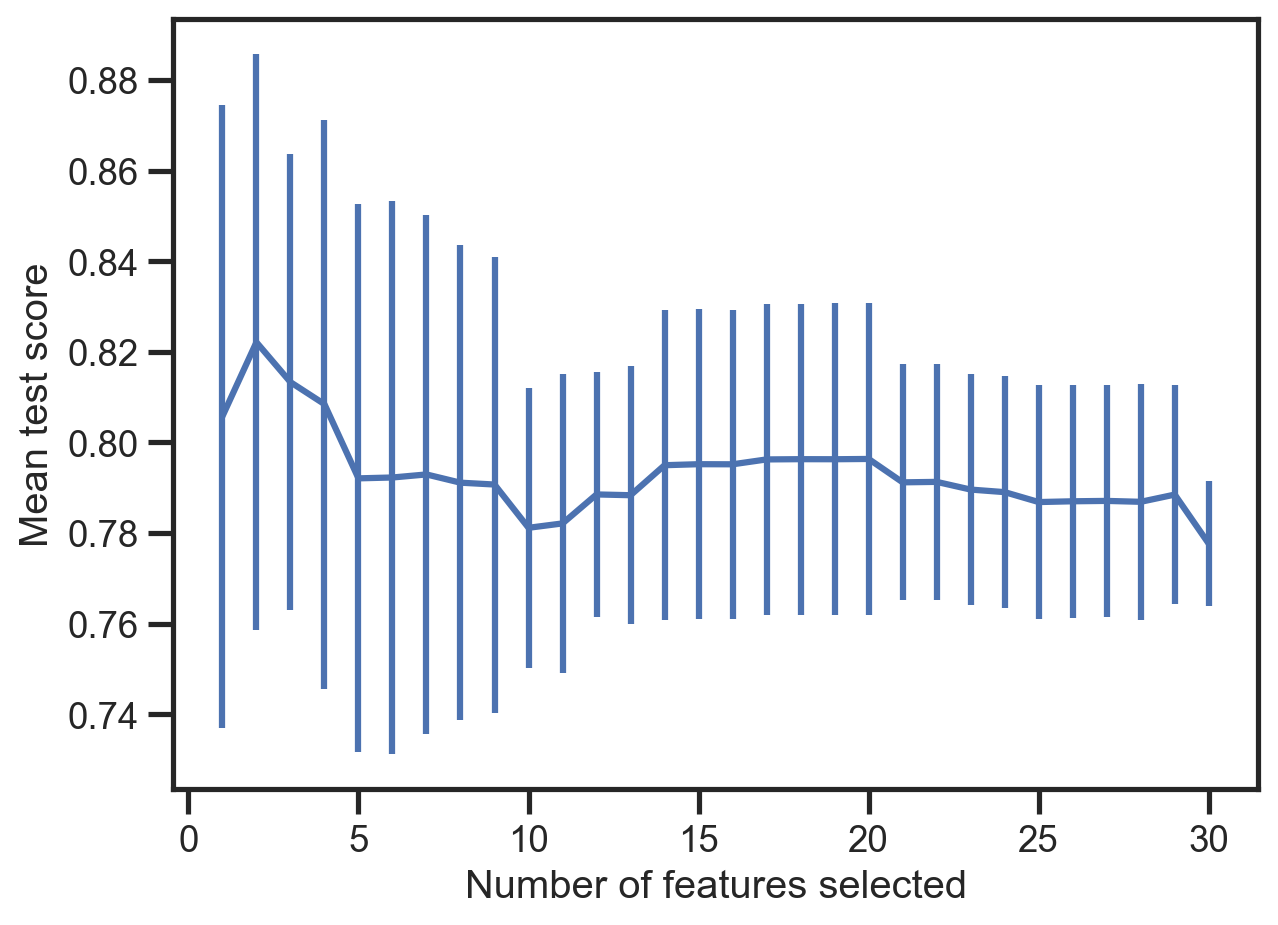

In [126]:
fig, ax = plt.subplots(figsize=(7,5))
ax.errorbar(
    range(1, n_scores+1),
    ref_selector.cv_results_["mean_test_score"],
    yerr=ref_selector.cv_results_["std_test_score"],
)
ax.set_xlabel("Number of features selected")
ax.set_ylabel("Mean test score");

### 3.3 Feature Selection With SequentialFeatureSelector

In [130]:
from sklearn.feature_selection import SequentialFeatureSelector

sfs_forward = SequentialFeatureSelector(
    Ridge(), n_features_to_select=7, direction="forward"
).fit(X_new, y)

In [131]:
sfs_forward.get_feature_names_out()

array(['body_SUV', 'mileage', 'model', 'car_age', 'mileage make',
       'model car_age', 'car_age^2'], dtype=object)

## 3.4 Dimensionality Reduction

In [116]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

In [117]:
pca = PCA(n_components=4)
X_new_pca = pca.fit(X_new)
X_new_pca

PCA(n_components=4)

In [120]:
X_new_pca.explained_variance_ratio_

array([9.21868192e-01, 7.61499056e-02, 8.25319828e-04, 4.21460178e-04])

In [127]:
pca.components_

array([[-3.24191856e-06,  3.48611454e-06, -2.44195987e-07,
        -1.00696371e-05,  1.77321956e-05, -7.66255857e-06,
        -1.12103042e-05,  3.80807089e-07,  1.08294971e-05,
         2.08181095e-06, -1.69705720e-05,  3.46135796e-04,
         4.62438555e-03,  1.16454903e-05,  1.60288384e-05,
        -2.22423093e-06, -2.37522001e-04, -2.79156900e-03,
        -6.09785187e-07, -1.40779308e-05,  1.66027699e-02,
         3.86414356e-02,  3.19960582e-05,  2.08065365e-04,
         9.99097822e-01,  2.89086006e-04,  2.28622933e-03,
         1.36927312e-04,  2.32857602e-06,  3.72502627e-06],
       [ 4.02093668e-05, -2.44217134e-05, -1.57876535e-05,
        -1.24949443e-04,  1.93986287e-04, -6.90368441e-05,
        -1.16764741e-04, -1.74361160e-05,  1.34200858e-04,
         2.40142042e-05, -2.05826451e-04,  1.07461270e-02,
         3.63848687e-03,  1.73418232e-04,  1.85822560e-04,
        -8.51147171e-05, -9.14718965e-03, -3.29795765e-03,
        -1.94678685e-04, -9.90115396e-05,  9.23403584e-

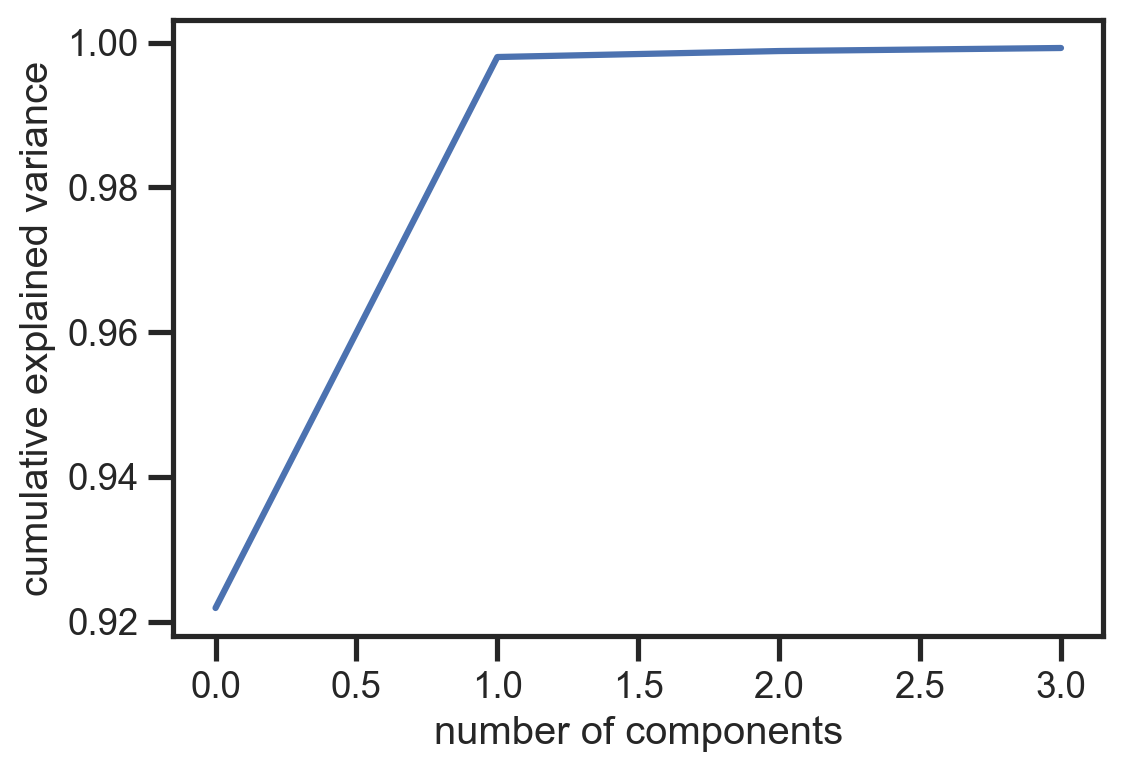

In [121]:
plt.plot(np.cumsum(X_new_pca.explained_variance_ratio_))
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance');

# 4 Model Building

## Grid Search For Optimal Model Configuations

In [30]:
X_new.shape, y.shape, X.shape

((402005, 30), (402005,), (402005, 9))

In [31]:
X_train, X_test, y_train, y_test = train_test_split(X_new, y, test_size = 0.3, random_state=0)
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((281403, 30), (281403,), (120602, 30), (120602,))

## Grid Search - Random Forest

In [31]:
# Configuration of grid parameters using max_depth & estimators

rf_grid_param = {
     'max_depth': [15, 20],
     'min_samples_split': [7,8],
     'min_samples_leaf': [7,8]
  }

# Instantiate the Gridsearch feature by passing the relevant grid parameters

rf_grid = GridSearchCV ( 
    RandomForestRegressor(),
    param_grid = rf_grid_param,
    scoring ='neg_mean_absolute_error',
    return_train_score=True,
    n_jobs =-1, 
    verbose =1)

In [32]:
rf_grid.fit(X_train,y_train)

Fitting 5 folds for each of 8 candidates, totalling 40 fits


GridSearchCV(estimator=RandomForestRegressor(), n_jobs=-1,
             param_grid={'max_depth': [15, 20], 'min_samples_leaf': [7, 8],
                         'min_samples_split': [7, 8]},
             return_train_score=True, scoring='neg_mean_absolute_error',
             verbose=1)

In [33]:
rf_grid.best_params_

{'max_depth': 20, 'min_samples_leaf': 7, 'min_samples_split': 7}

In [36]:
rf_grid_results = pd.DataFrame(rf_grid.cv_results_).sort_values('rank_test_score')
rf_grid_results.columns

Index(['mean_fit_time', 'std_fit_time', 'mean_score_time', 'std_score_time',
       'param_max_depth', 'param_min_samples_leaf', 'param_min_samples_split',
       'params', 'split0_test_score', 'split1_test_score', 'split2_test_score',
       'split3_test_score', 'split4_test_score', 'mean_test_score',
       'std_test_score', 'rank_test_score', 'split0_train_score',
       'split1_train_score', 'split2_train_score', 'split3_train_score',
       'split4_train_score', 'mean_train_score', 'std_train_score'],
      dtype='object')

In [37]:
rf_grid_results[['param_max_depth', 'param_min_samples_split', 'param_min_samples_leaf',
                 'mean_train_score', 'mean_test_score', 'rank_test_score']]

,param_max_depth,param_min_samples_split,param_min_samples_leaf,mean_train_score,mean_test_score,rank_test_score
4,20,7,7,-1836.632585,-2153.746829,1
5,20,8,7,-1839.622906,-2156.898036,2
7,20,8,8,-1869.749410,-2160.946953,3
6,20,7,8,-1869.682759,-2165.574007,4
1,15,8,7,-2089.602243,-2273.755609,5
0,15,7,7,-2088.027539,-2275.175662,6
3,15,8,8,-2109.012383,-2283.558765,7
2,15,7,8,-2107.484254,-2284.679985,8


## Grid Search - Gradient Boosting Regressor

In [32]:
gb_grid_param = {
     'max_depth': [10, 15],
     'learning_rate': [0.1, 0.2]
  }

# Instantiate the Gridsearch feature by passing the relevant grid parameters

gb_grid = GridSearchCV ( 
    GradientBoostingRegressor(),
    param_grid = gb_grid_param,
    scoring ='neg_mean_absolute_error',
    return_train_score=True,
    n_jobs =-1, 
    verbose =1)

In [33]:
gb_grid.fit(X_train,y_train)

Fitting 5 folds for each of 4 candidates, totalling 20 fits


GridSearchCV(estimator=GradientBoostingRegressor(), n_jobs=-1,
             param_grid={'learning_rate': [0.1, 0.2], 'max_depth': [10, 15]},
             return_train_score=True, scoring='neg_mean_absolute_error',
             verbose=1)

In [34]:
gb_grid.best_params_

{'learning_rate': 0.1, 'max_depth': 15}

In [35]:
gb_grid_results = pd.DataFrame(gb_grid.cv_results_).sort_values('rank_test_score')
gb_grid_results.columns

Index(['mean_fit_time', 'std_fit_time', 'mean_score_time', 'std_score_time',
       'param_learning_rate', 'param_max_depth', 'params', 'split0_test_score',
       'split1_test_score', 'split2_test_score', 'split3_test_score',
       'split4_test_score', 'mean_test_score', 'std_test_score',
       'rank_test_score', 'split0_train_score', 'split1_train_score',
       'split2_train_score', 'split3_train_score', 'split4_train_score',
       'mean_train_score', 'std_train_score'],
      dtype='object')

In [36]:
gb_grid_results[['param_max_depth', 'param_learning_rate',
                 'mean_train_score', 'mean_test_score', 'rank_test_score']]

,param_max_depth,param_learning_rate,mean_train_score,mean_test_score,rank_test_score
1,15,0.1,-1275.359202,-2058.307162,1
2,10,0.2,-1598.539137,-2084.833527,2
3,15,0.2,-1107.097234,-2097.139995,3
0,10,0.1,-1801.815822,-2151.501466,4


## Grid Search - Ridge Model

In [41]:
rd_grid_param = dict(
    alpha=np.logspace(-3, 3, 7)
)

rd_grid = GridSearchCV (
    Ridge(),
    param_grid = rd_grid_param,
    return_train_score = True, 
    scoring = 'neg_root_mean_squared_error'
)

In [42]:
rd_grid.fit(X_train,y_train)

GridSearchCV(estimator=Ridge(),
             param_grid={'alpha': array([1.e-03, 1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02, 1.e+03])},
             return_train_score=True, scoring='neg_root_mean_squared_error')

In [43]:
rd_grid.best_params_

{'alpha': 1000.0}

In [44]:
rd_grid_results = pd.DataFrame(rd_grid.cv_results_).sort_values('rank_test_score')
rd_grid_results.columns

Index(['mean_fit_time', 'std_fit_time', 'mean_score_time', 'std_score_time',
       'param_alpha', 'params', 'split0_test_score', 'split1_test_score',
       'split2_test_score', 'split3_test_score', 'split4_test_score',
       'mean_test_score', 'std_test_score', 'rank_test_score',
       'split0_train_score', 'split1_train_score', 'split2_train_score',
       'split3_train_score', 'split4_train_score', 'mean_train_score',
       'std_train_score'],
      dtype='object')

In [45]:
rd_grid_results[['param_alpha','mean_train_score','mean_test_score','rank_test_score']]

,param_alpha,mean_train_score,mean_test_score,rank_test_score
6,1000.0,-10421.583094,-10716.073955,1
5,100.0,-10410.105496,-10735.670890,2
4,10.0,-10409.961165,-10739.235643,3
3,1.0,-10409.959685,-10739.611958,4
2,0.1,-10409.959670,-10739.649793,5
1,0.01,-10409.959670,-10739.653578,6
0,0.001,-10409.959670,-10739.653957,7


## Linear Regression Models With Optimal Configurations

In [46]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state=0)
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((281403, 9), (281403,), (120602, 9), (120602,))

## Dummy regressor to set baseline

In [47]:
dm_pipeline = Pipeline(
    steps=[
        ("preprocessor", preprocessor), 
        ("regr", DummyRegressor())
    ]
).set_output(transform="pandas")

dm_pipeline.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('cat',
                                                  Pipeline(steps=[('ohe',
                                                                   OneHotEncoder(drop='if_binary',
                                                                                 handle_unknown='ignore',
                                                                                 sparse_output=False))]),
                                                  ['colour', 'body', 'fuel',
                                                   'condition']),
                                                 ('num',
                                                  Pipeline(steps=[('scaler',
                                                                   StandardScaler()),
                                                                  ('poly',
                                                                   PolynomialFeatures(include_bias=False))]),
                                                  ['mileage', 'make', 'model',
                                                   'car_age',
                                                   'mileage_cluster'])],
                                   verbose_feature_names_out=False)),
                ('regr', DummyRegressor())])

In [48]:
# Dummy Regression

Dummy_RMSE = rmse(y_test, dm_pipeline.predict(X_test))
Dummy_MAE =  mean_absolute_error(y_test, dm_pipeline.predict(X_test))
Dummy_rscore = r2_score(y_test, dm_pipeline.predict(X_test))

In [49]:
print("Root Mean Squared Error: ", Dummy_RMSE)
print("Mean Absolute Error: ", Dummy_MAE)
print("R-squared: ", Dummy_rscore)

Root Mean Squared Error:  62928.62498616435
Mean Absolute Error:  11077.806959836187
R-squared:  -1.1052652253873418e-05


# Linear Regression Model Using Sklearn

In [50]:
lr_pipeline = Pipeline(
    steps=[
        ("preprocessor", preprocessor), 
        ("regr", LinearRegression())
    ]
).set_output(transform="pandas")

In [51]:
lr_pipeline.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('cat',
                                                  Pipeline(steps=[('ohe',
                                                                   OneHotEncoder(drop='if_binary',
                                                                                 handle_unknown='ignore',
                                                                                 sparse_output=False))]),
                                                  ['colour', 'body', 'fuel',
                                                   'condition']),
                                                 ('num',
                                                  Pipeline(steps=[('scaler',
                                                                   StandardScaler()),
                                                                  ('poly',
                                                                   PolynomialFeatures(include_bias=False))]),
                                                  ['mileage', 'make', 'model',
                                                   'car_age',
                                                   'mileage_cluster'])],
                                   verbose_feature_names_out=False)),
                ('regr', LinearRegression())])

In [52]:
lr_predict = lr_pipeline.predict(X_test)
lr_predict

array([25132.48131959,  9728.21392522, 21554.99665404, ...,
        1063.64924607, 23480.6061004 , 14163.97947477])

In [53]:
LR_RMSE = rmse(y_test, lr_predict)

In [54]:
LR_rscore = r2_score(y_test, lr_predict)

In [55]:
LR_MAE = mean_absolute_error(y_test, lr_predict)

In [ ]:
lm_cvs = cross_val_score(lr_pipeline, X_train, y_train, cv=10, 
                         scoring='neg_root_mean_squared_error')*-1
lm_cvs

In [ ]:
np.mean(lm_cvs), np.std(lm_cvs)

In [56]:
print("Root Mean Squared Error: ", LR_RMSE)
print("R-squared: ", LR_rscore)
print("Mean Absolute Error: ", LR_MAE)

Root Mean Squared Error:  34081.440532885856
R-squared:  0.7066782946366261
Mean Absolute Error:  3714.467663324765


## Linear Regression Using Ridge 

In [57]:
ridge_pipeline = Pipeline(
    steps=[
        ("preprocessor", preprocessor), 
        ("regr", Ridge(alpha=1000))
    ]
).set_output(transform="pandas")

In [58]:
ridge_pipeline.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('cat',
                                                  Pipeline(steps=[('ohe',
                                                                   OneHotEncoder(drop='if_binary',
                                                                                 handle_unknown='ignore',
                                                                                 sparse_output=False))]),
                                                  ['colour', 'body', 'fuel',
                                                   'condition']),
                                                 ('num',
                                                  Pipeline(steps=[('scaler',
                                                                   StandardScaler()),
                                                                  ('poly',
                                                                   PolynomialFeatures(include_bias=False))]),
                                                  ['mileage', 'make', 'model',
                                                   'car_age',
                                                   'mileage_cluster'])],
                                   verbose_feature_names_out=False)),
                ('regr', Ridge(alpha=1000))])

In [59]:
rg_predict = ridge_pipeline.predict(X_test)
rg_predict

array([25258.51732196,  9715.33477541, 21657.39497985, ...,
        1073.37947663, 23524.33436026, 14202.64944412])

In [60]:
RG_MAE = mean_absolute_error(y_test, rg_predict)

In [61]:
RG_RMSE = rmse(y_test, rg_predict)

In [62]:
RG_rscore = r2_score(y_test, rg_predict)

In [ ]:
rg_scores = cross_val_score(
    ridge_pipeline, X_train, y_train, cv=10, scoring='neg_root_mean_squared_error'
)*-1
rg_scores.mean(), rg_scores.std()

In [63]:
print("Root Mean Squared Error: ", RG_RMSE)
print("R-squared: ", RG_rscore)
print("Mean Absolute Error: ", RG_MAE)

Root Mean Squared Error:  34657.919147448665
R-squared:  0.6966714536497918
Mean Absolute Error:  3710.4960499807053


# Random Forest Regressor

In [65]:
regr_pipe = Pipeline(
    steps=[
        ("preprocessor", preprocessor), 
        ("regr", RandomForestRegressor(
              max_depth=20, 
              min_samples_leaf = 7,
              min_samples_split = 7
        ))
    ]
).set_output(transform="pandas")

In [66]:
regr_pipe.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('cat',
                                                  Pipeline(steps=[('ohe',
                                                                   OneHotEncoder(drop='if_binary',
                                                                                 handle_unknown='ignore',
                                                                                 sparse_output=False))]),
                                                  ['colour', 'body', 'fuel',
                                                   'condition']),
                                                 ('num',
                                                  Pipeline(steps=[('scaler',
                                                                   StandardScaler()),
                                                                  ('poly',
                                                                   PolynomialFeatures(include_bias=False))]),
                                                  ['mileage', 'make', 'model',
                                                   'car_age',
                                                   'mileage_cluster'])],
                                   verbose_feature_names_out=False)),
                ('regr',
                 RandomForestRegressor(max_depth=20, min_samples_leaf=7,
                                       min_samples_split=7))])

In [67]:
rf_predict = regr_pipe.predict(X_test)
rf_predict

array([21957.07400753,  8791.59188994, 25675.405947  , ...,
        2044.16846289, 21773.52095559, 15005.26111298])

In [68]:
RF_MAE = mean_absolute_error(y_test, rf_predict)

In [69]:
RF_RMSE = rmse(y_test, rf_predict)

In [70]:
RF_rscore = r2_score(y_test, rf_predict)

In [71]:
print("Root Mean Squared Error: ", RF_RMSE)
print("R-squared: ", RF_rscore)
print("Mean Absolute Error: ", RF_MAE)

Root Mean Squared Error:  47341.16735624875
R-squared:  0.4340393446389691
Mean Absolute Error:  2331.9176666843705


# Gradient Boosting Regressor

In [72]:
gb_regr_pipe = Pipeline(
    steps=[
        ("preprocessor", preprocessor), 
        ("regr", GradientBoostingRegressor(
              max_depth=15, learning_rate = 0.1
        ))
    ]
).set_output(transform="pandas")

In [73]:
gb_regr_pipe.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('cat',
                                                  Pipeline(steps=[('ohe',
                                                                   OneHotEncoder(drop='if_binary',
                                                                                 handle_unknown='ignore',
                                                                                 sparse_output=False))]),
                                                  ['colour', 'body', 'fuel',
                                                   'condition']),
                                                 ('num',
                                                  Pipeline(steps=[('scaler',
                                                                   StandardScaler()),
                                                                  ('poly',
                                                                   PolynomialFeatures(include_bias=False))]),
                                                  ['mileage', 'make', 'model',
                                                   'car_age',
                                                   'mileage_cluster'])],
                                   verbose_feature_names_out=False)),
                ('regr', GradientBoostingRegressor(max_depth=15))])

In [74]:
gb_predict = gb_regr_pipe.predict(X_test)
gb_predict

array([22275.8924076 ,  8767.02187606, 25845.16707181, ...,
        2120.17919913, 21873.09387019, 15178.75178754])

In [75]:
GB_RMSE = rmse(y_test, gb_predict)

In [76]:
GB_MAE = mean_absolute_error(y_test, gb_predict)

In [77]:
GB_rscore = r2_score(y_test, gb_predict)

In [78]:
print("Root Mean Squared Error: ", GB_RMSE)
print("R-squared: ", GB_rscore)
print("Mean Absolute Error: ", GB_MAE)

Root Mean Squared Error:  38243.32345654341
R-squared:  0.6306657625802325
Mean Absolute Error:  2171.227086466263


### Regressor Models Evaluation

In [79]:
# Create dataframe of Performance metrics
model_performance = pd.DataFrame({
    'Model': ['Dummy','Linear', 'Ridge','Random Forest', 'Gradient Boosting'],
    'MAE': [Dummy_MAE, LR_MAE, RG_MAE, RF_MAE, GB_MAE],
    'RMSE': [Dummy_RMSE, LR_RMSE, RG_RMSE, RF_RMSE, GB_RMSE],
    'R-Squared': [Dummy_rscore, LR_rscore, RG_rscore, RF_rscore, GB_rscore]
})

In [80]:
model_performance.sort_values(by='MAE')

,Model,MAE,RMSE,R-Squared
4,Gradient Boosting,2171.227086,38243.323457,0.630666
3,Random Forest,2331.917667,47341.167356,0.434039
2,Ridge,3710.496050,34657.919147,0.696671
1,Linear,3714.467663,34081.440533,0.706678
0,Dummy,11077.806960,62928.624986,-0.000011


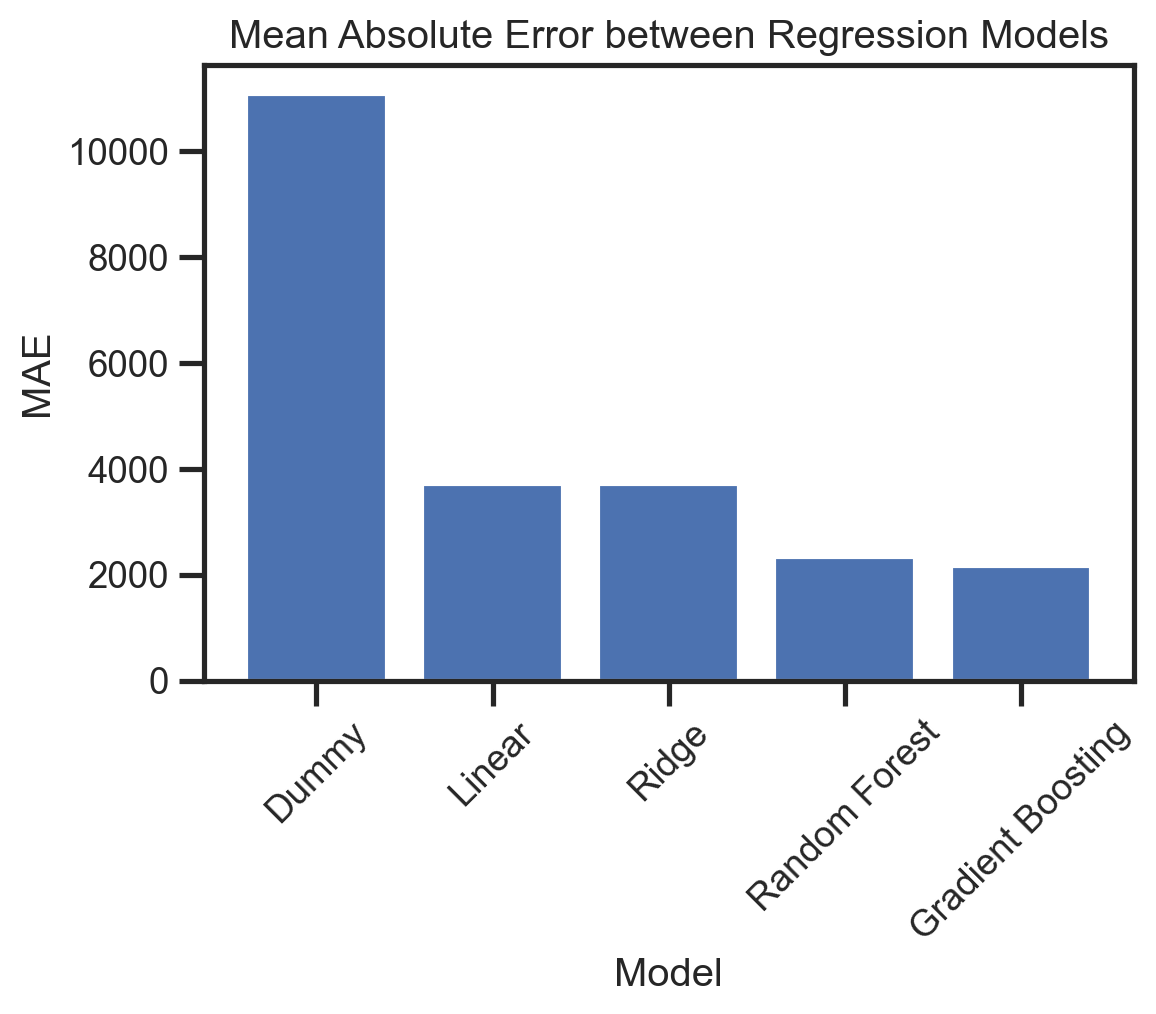

In [81]:
# Create bar plot of Mean Absolute Error for each model
plt.bar(model_performance['Model'], model_performance['MAE'])
plt.xticks(rotation=45)
plt.xlabel('Model')
plt.ylabel('MAE')
plt.title('Mean Absolute Error between Regression Models')
plt.show()

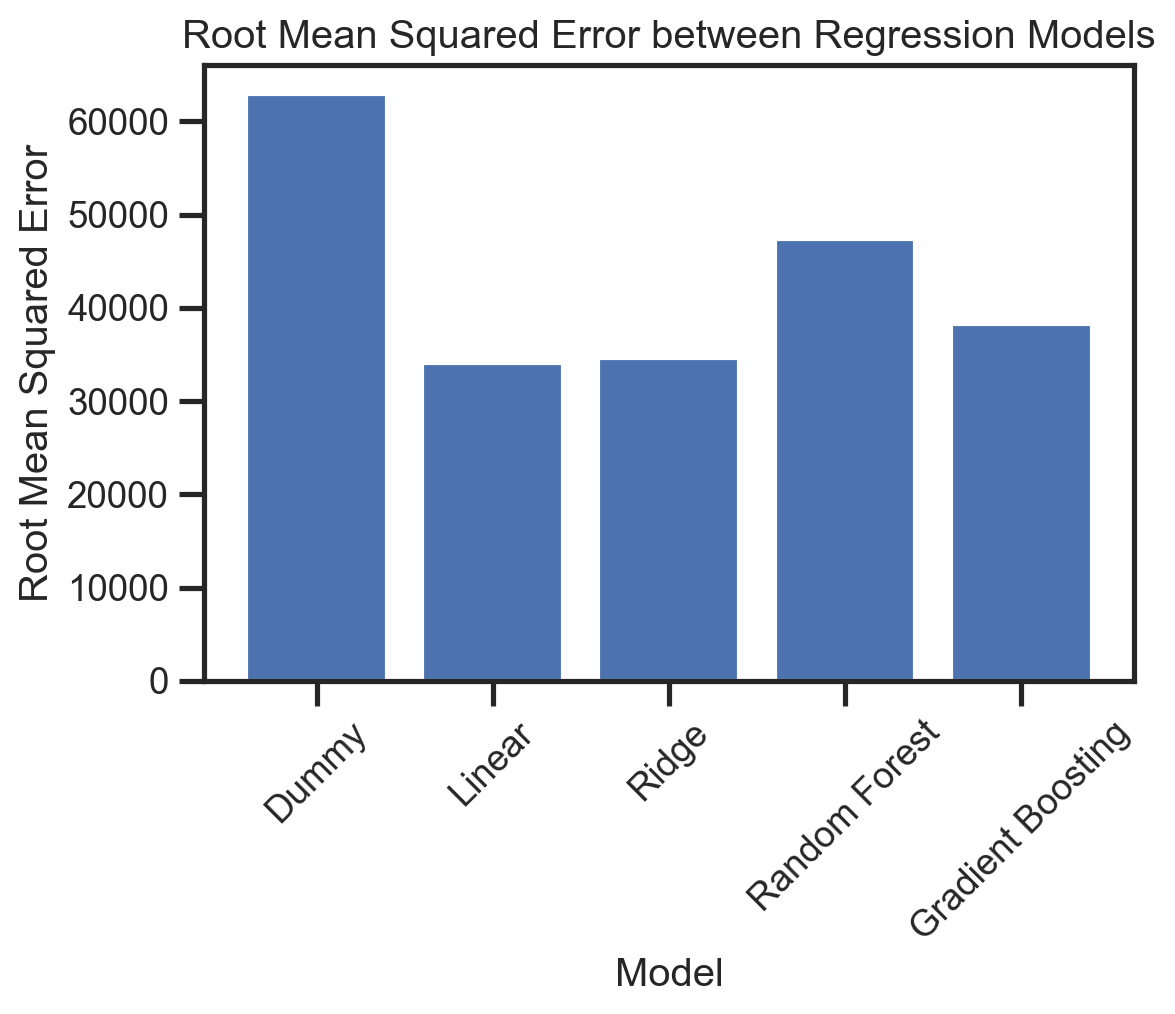

In [82]:
# Create bar plot of Root Mean Squared Error for each model
plt.bar(model_performance['Model'], model_performance['RMSE'])
plt.xticks(rotation=45)
plt.xlabel('Model')
plt.ylabel('Root Mean Squared Error')
plt.title('Root Mean Squared Error between Regression Models')
plt.show()

#  Averager / Voter / Stacker Ensemble

In [83]:
hgb_pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                               ('regressor', HistGradientBoostingRegressor())])

In [84]:
hgb_pipeline

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('cat',
                                                  Pipeline(steps=[('ohe',
                                                                   OneHotEncoder(drop='if_binary',
                                                                                 handle_unknown='ignore',
                                                                                 sparse_output=False))]),
                                                  ['colour', 'body', 'fuel',
                                                   'condition']),
                                                 ('num',
                                                  Pipeline(steps=[('scaler',
                                                                   StandardScaler()),
                                                                  ('poly',
                                                                   PolynomialFeatures(include_bias=False))]),
                                                  ['mileage', 'make', 'model',
                                                   'car_age',
                                                   'mileage_cluster'])],
                                   verbose_feature_names_out=False)),
                ('regressor', HistGradientBoostingRegressor())])

In [85]:
ensembled = [ lr_pipeline, regr_pipe, gb_regr_pipe, hgb_pipeline ]

In [86]:
for est in ensembled:
    est.fit(X_train, y_train)

In [87]:
ensemble = VotingRegressor(
    [
        ("lr", lr_pipeline),
        ("rf", regr_pipe),
        ("gb", gb_regr_pipe),  
        ("hbg", hgb_pipeline)
    ]
)
ensemble.fit(X_train, y_train)

VotingRegressor(estimators=[('lr',
                             Pipeline(steps=[('preprocessor',
                                              ColumnTransformer(remainder='passthrough',
                                                                transformers=[('cat',
                                                                               Pipeline(steps=[('ohe',
                                                                                                OneHotEncoder(drop='if_binary',
                                                                                                              handle_unknown='ignore',
                                                                                                              sparse_output=False))]),
                                                                               ['colour',
                                                                                'body',
                                                                                'fuel',
                                                                                'condition']),
                                                                              ('num',
                                                                               Pipeline(steps=[('scaler',
                                                                                                StandardScaler()),
                                                                                               ('poly',
                                                                                                PolynomialFeatures(inc...
                                                                                                OneHotEncoder(drop='if_binary',
                                                                                                              handle_unknown='ignore',
                                                                                                              sparse_output=False))]),
                                                                               ['colour',
                                                                                'body',
                                                                                'fuel',
                                                                                'condition']),
                                                                              ('num',
                                                                               Pipeline(steps=[('scaler',
                                                                                                StandardScaler()),
                                                                                               ('poly',
                                                                                                PolynomialFeatures(include_bias=False))]),
                                                                               ['mileage',
                                                                                'make',
                                                                                'model',
                                                                                'car_age',
                                                                                'mileage_cluster'])],
                                                                verbose_feature_names_out=False)),
                                             ('regressor',
                                              HistGradientBoostingRegressor())]))])

# Voter Ensemble Model Performance with Cross-Validation

In [88]:
all_regr = ensembled + [ ensemble ]

In [132]:
all_regr = ensembled + [ensemble]

# Initialize lists to store model names and respective scores
model_name = []
rmse_score = []
std_score = []

# Loop over each model, calculate the cross-validation scores and store them in the lists
for est in all_regr:
    if isinstance(est, Pipeline):
        model = est.steps[-1][1]
        name = type(model).__name__
    else:
        name = type(est).__name__
    model_name.append(name)
    scores = cross_val_score(est, X_train, y_train, cv=5, scoring='neg_root_mean_squared_error')
    rmse_score.append(scores.mean() * -1)
    std_score.append(scores.std())


In [133]:
# Create a dataframe with the model name and respective scores
cv_scores = pd.DataFrame({
    'Model': model_name,
    'RMSE': rmse_score,
    'Std Dev': std_score
})

cv_scores

,Model,RMSE,Std Dev
0,LinearRegression,10739.667016,515.253360
1,RandomForestRegressor,19653.292404,10325.828782
2,GradientBoostingRegressor,10580.490139,1717.183397
3,HistGradientBoostingRegressor,27251.053214,12349.607489
4,VotingRegressor,13518.657297,5383.651609


# Voter Ensemble True vs Predicted Analysis 

In [89]:
# Inspection of Model Output
top_50 = X.head(50)
lr_pred = lr_pipeline.predict(top_50)
gb_pred = gb_regr_pipe.predict(top_50)
rf_pred = regr_pipe.predict(top_50)
hg_pred = hgb_pipeline.predict(top_50)
en_pred = ensemble.predict(top_50)

In [90]:
# Create a dataframe to view predicted prices of all three regressor models and their average
# Alongside the true price

model_prediction = pd.DataFrame({
    'GB_Price': gb_pred.round(2),
    'RF_Price': rf_pred.round(2),
    'HG_Price': hg_pred.round(2),
    'LR_Price': lr_pred.round(2),
    'Ensemble_Price': en_pred.round(2)
})

# Add the true values to the DataFrame
model_prediction['True Price'] = y.head(50).values

In [91]:
# Display the DataFrame
model_prediction.head()

,GB_Price,RF_Price,HG_Price,LR_Price,Ensemble_Price,True Price
0,60487.25,60367.57,56067.23,52725.63,58183.05,73970.0
1,6428.40,7001.08,7016.12,6440.82,6429.16,7000.0
2,13811.10,13516.03,12717.41,13200.70,13274.30,14000.0
3,8485.28,8661.21,8059.50,7345.13,8062.20,7995.0
4,31919.89,31886.69,26872.70,26509.67,29913.23,26995.0


In [92]:
# Calculate mean absolute error for each model in the ensemble for the top 50 instances

mae_lr = mean_absolute_error(y.head(50), lr_pred)
mae_gb = mean_absolute_error(y.head(50), gb_pred)
mae_rf = mean_absolute_error(y.head(50), rf_pred)
mae_hg = mean_absolute_error(y.head(50), hg_pred)
mae_en = mean_absolute_error(y.head(50), en_pred)

# Display the mean absolute errors
print("Mean Absolute Error - LR: ", mae_lr)
print("Mean Absolute Error - GB: ", mae_gb)
print("Mean Absolute Error - RF: ", mae_rf)
print("Mean Absolute Error - HGB: ", mae_hg)
print("Mean Absolute Error - Ensemble: ", mae_en)

Mean Absolute Error - LR:  4803.455518449105
Mean Absolute Error - GB:  1687.2830491868629
Mean Absolute Error - RF:  2416.3137063685267
Mean Absolute Error - HGB:  4110.550945266779
Mean Absolute Error - Ensemble:  2927.958196262147


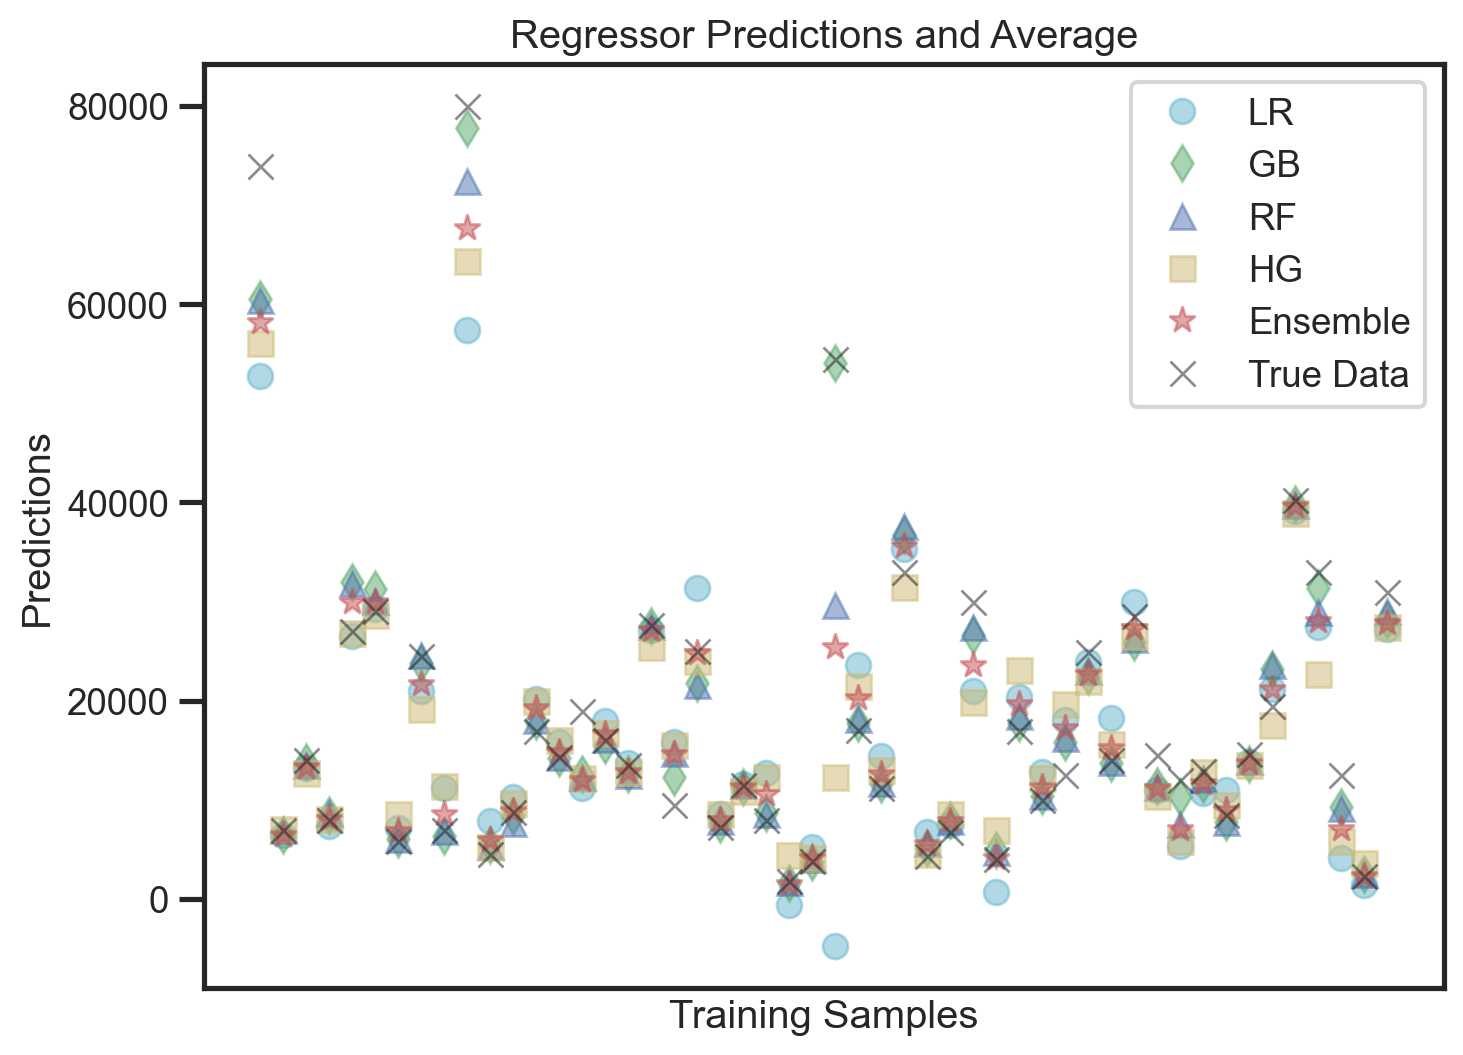

In [93]:
plt.figure(figsize=(8,6))
plt.plot(lr_pred, "oc", alpha=0.5, label="LR")
plt.plot(gb_pred, "gd", alpha=0.5, label="GB")
plt.plot(rf_pred, "b^", alpha=0.5, label="RF")
plt.plot(hg_pred, "ys", alpha=0.5, label="HG")
plt.plot(en_pred, "r*", alpha=0.5, ms=10, label="Ensemble")
plt.plot(y.head(50), "kx", alpha=0.5, label="True Data")

plt.tick_params(axis="x", which="both", bottom=False, top=False, labelbottom=False)
plt.ylabel("Predictions")
plt.xlabel("Training Samples")
plt.legend(loc="best")
plt.title("Regressor Predictions and Average")

plt.show()

In [ ]:
instance = X.head(1)
(lr_pipeline.predict(instance), gb_regr_pipe.predict(instance), regr_pipe.predict(instance), 
 hgb_pipeline.predict(instance), ensemble.predict(instance))

# Global and Local Explanations with SHAP

# Global Explanation With SHAP

In [94]:
#Instantiate eplainer object for local & global analysis on gradient boosting model

rfc_explainer = shap.TreeExplainer(gb_regr_pipe['regr'])

In [ ]:
'''
rfc_shap_values = rfc_explainer.shap_values(
    regr_pipeline['preprocessor'].transform(X)
)

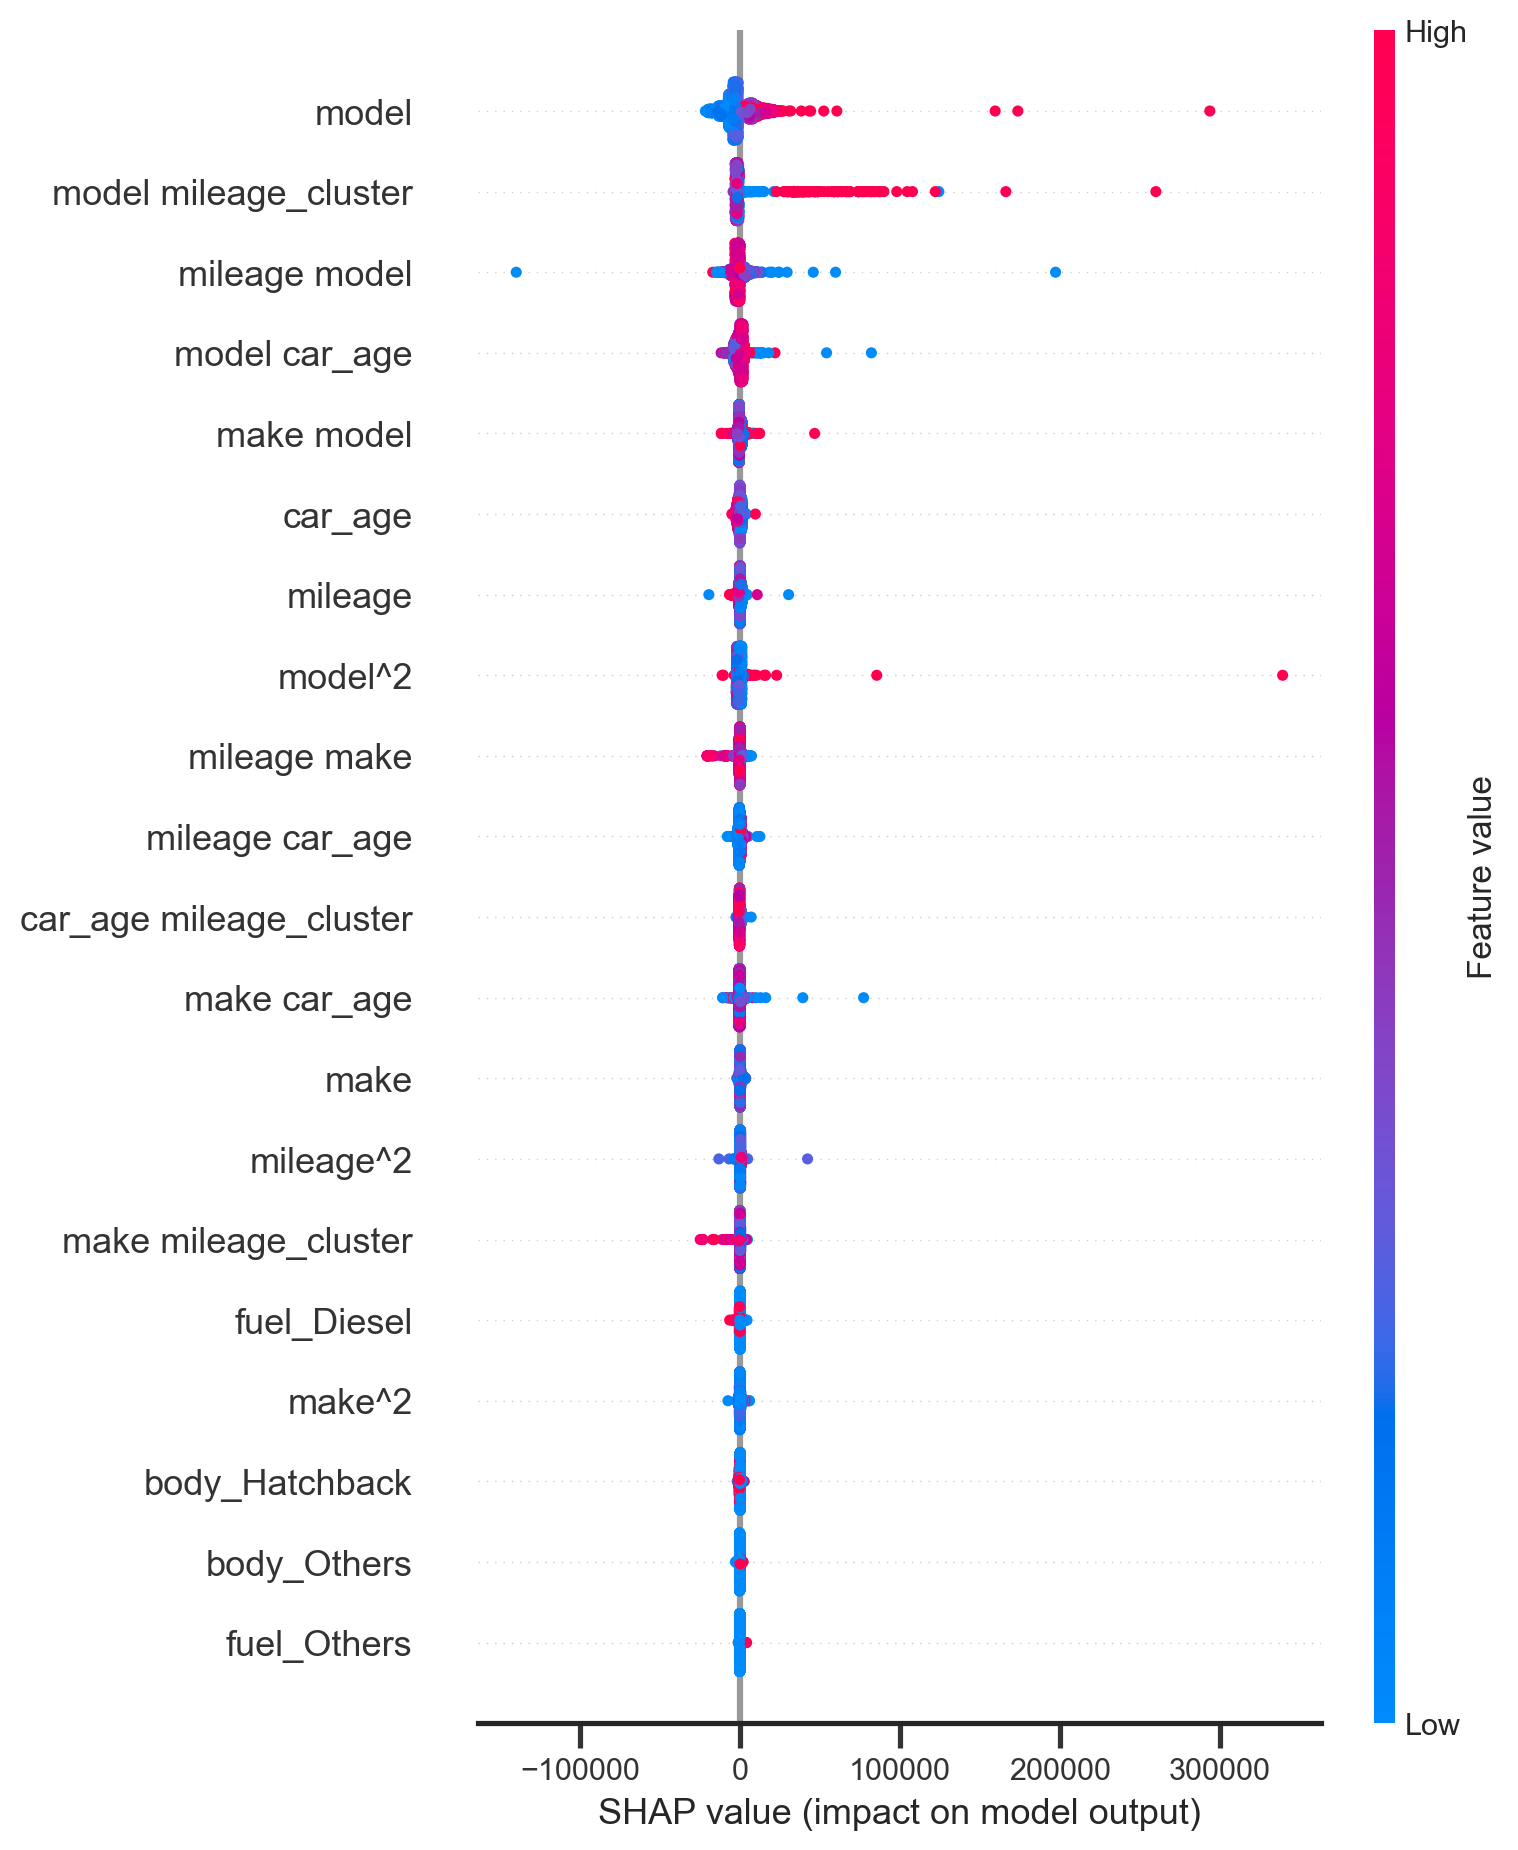

In [107]:
rfc_shap_values = rfc_explainer.shap_values(
    gb_regr_pipe['preprocessor'].transform(X[:5000])
)

shap.summary_plot(
    rfc_shap_values, 
    gb_regr_pipe['preprocessor'].transform(X[:5000])
)


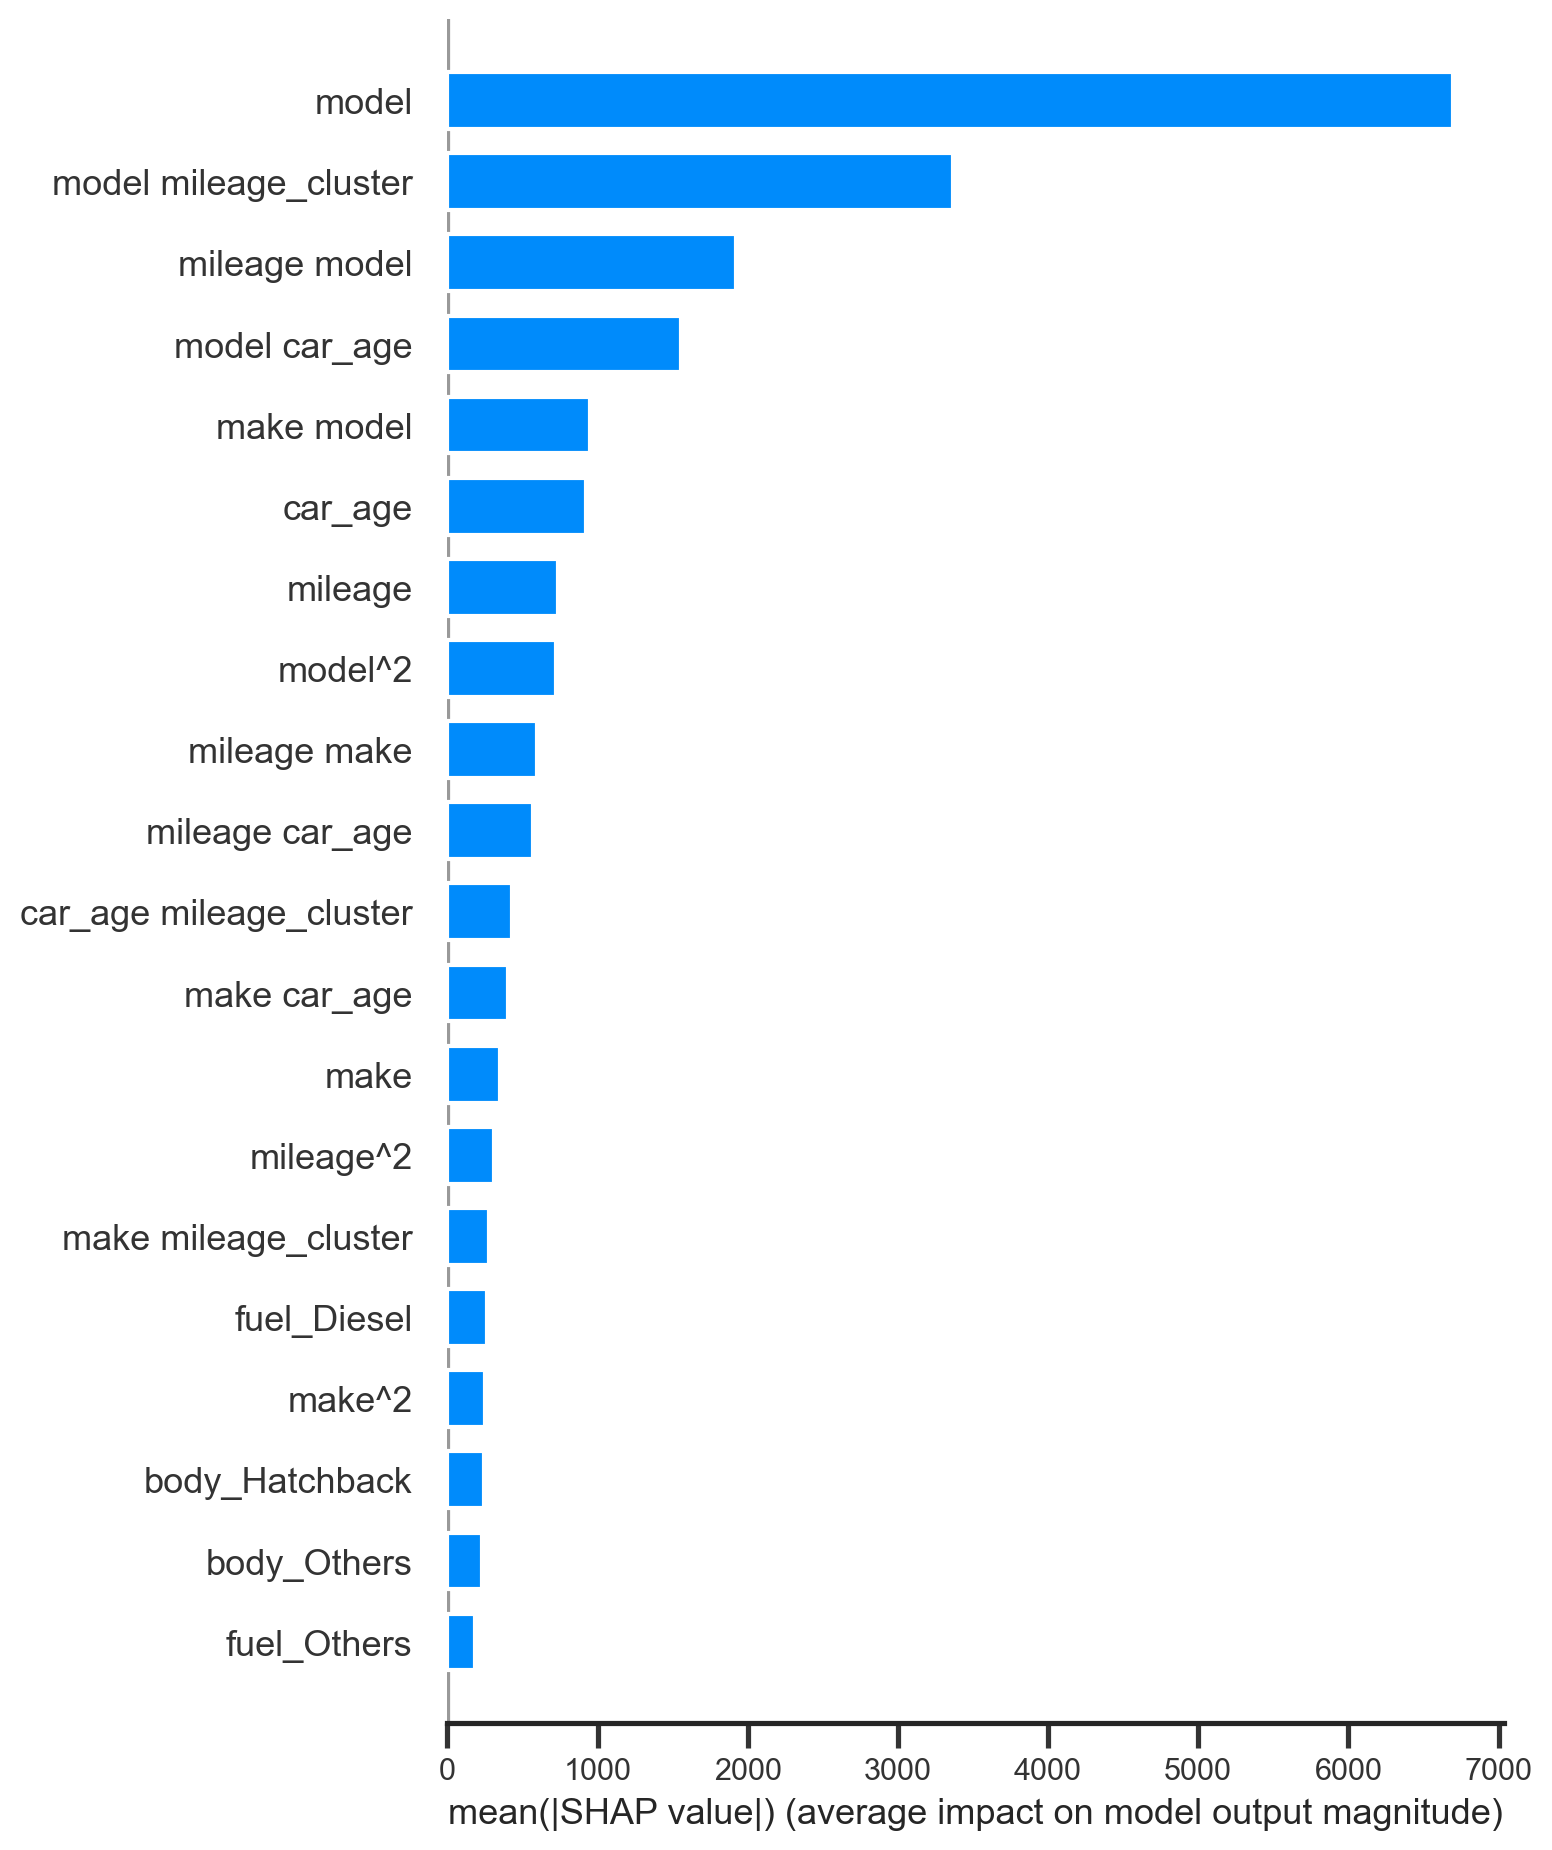

In [106]:
shap.summary_plot(rfc_shap_values, regr_pipe['preprocessor'].transform(X[:3000]), plot_type="bar")

# Local Explanation With Shap (Instance Level)

In [95]:
# Obtain SHAP values for local (single) instance on the test data using the instantiated explainer object

shap_val = rfc_explainer.shap_values(
    gb_regr_pipe['preprocessor'].transform(X[1:2])
)

In [136]:
# Force plot explaining single instance of SHAP Value

shap.force_plot(rfc_explainer.expected_value, shap_val, gb_regr_pipe['preprocessor'].transform(X[1:2]))

In [97]:
y[1:2]

1    7000.0
Name: price, dtype: float64

# Partial Dependency Plots

In [98]:
from sklearn.inspection import PartialDependenceDisplay

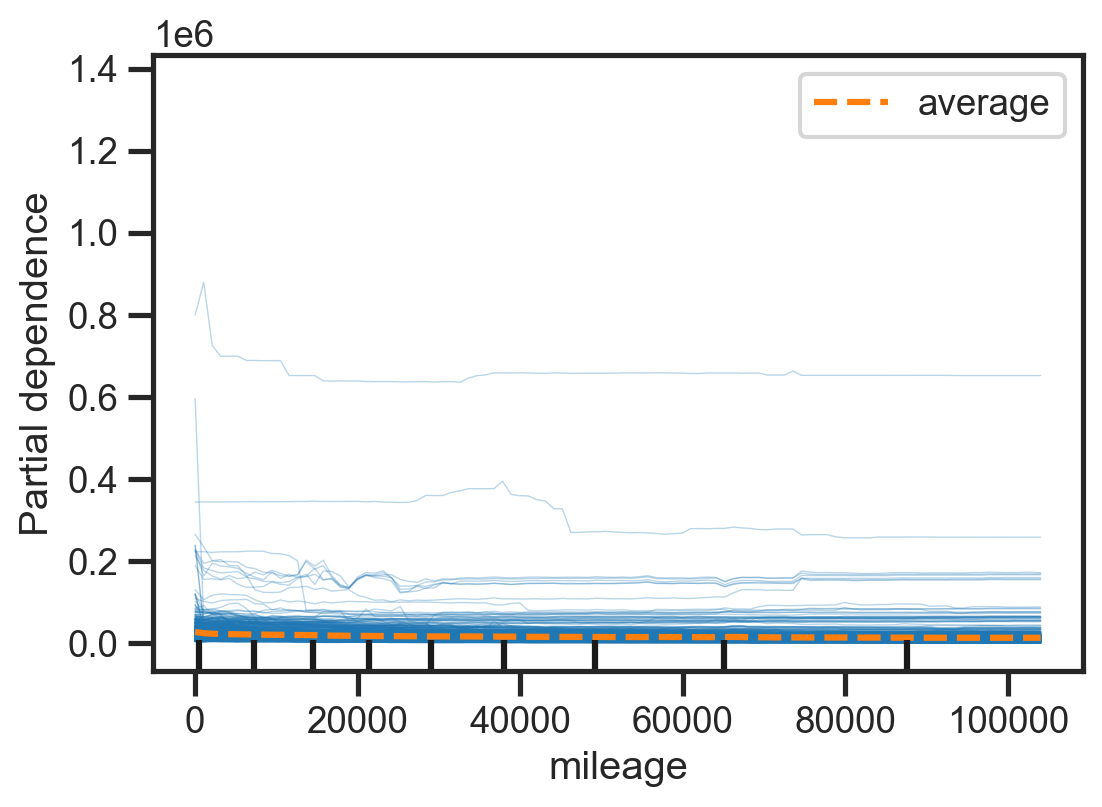

In [99]:
PartialDependenceDisplay.from_estimator(
    gb_regr_pipe, X_test[:5000], features=['mileage'], kind='both'
);

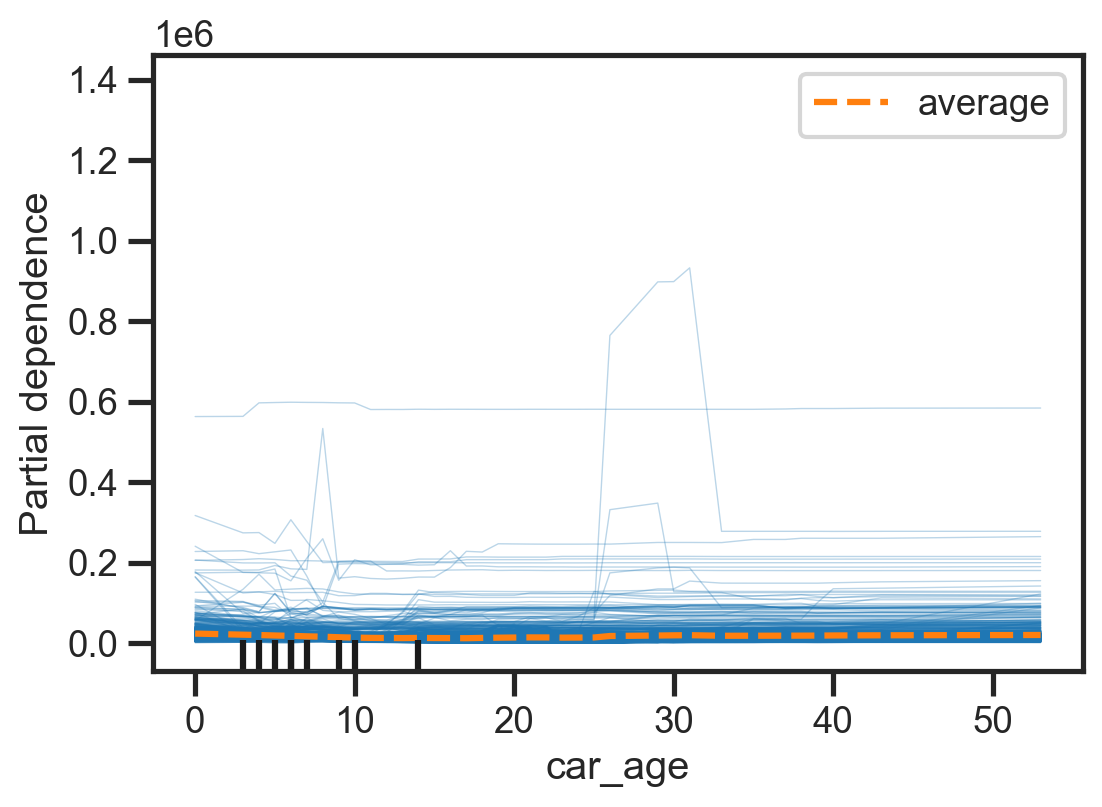

In [100]:
PartialDependenceDisplay.from_estimator(
    gb_regr_pipe, X_test[:5000], features=['car_age'], kind='both'
);

In [ ]:
fig, ax = plt.subplots(figsize=(8,6), constrained_layout=True)
PartialDependenceDisplay.from_estimator(
    gb_regr_pipe, X_test, features=['car_age', 'mileage', 'model', 'make'],
    kind='both',
    subsample=1000, grid_resolution=30, n_jobs=2, random_state=0,
    ax=ax, n_cols=2
);

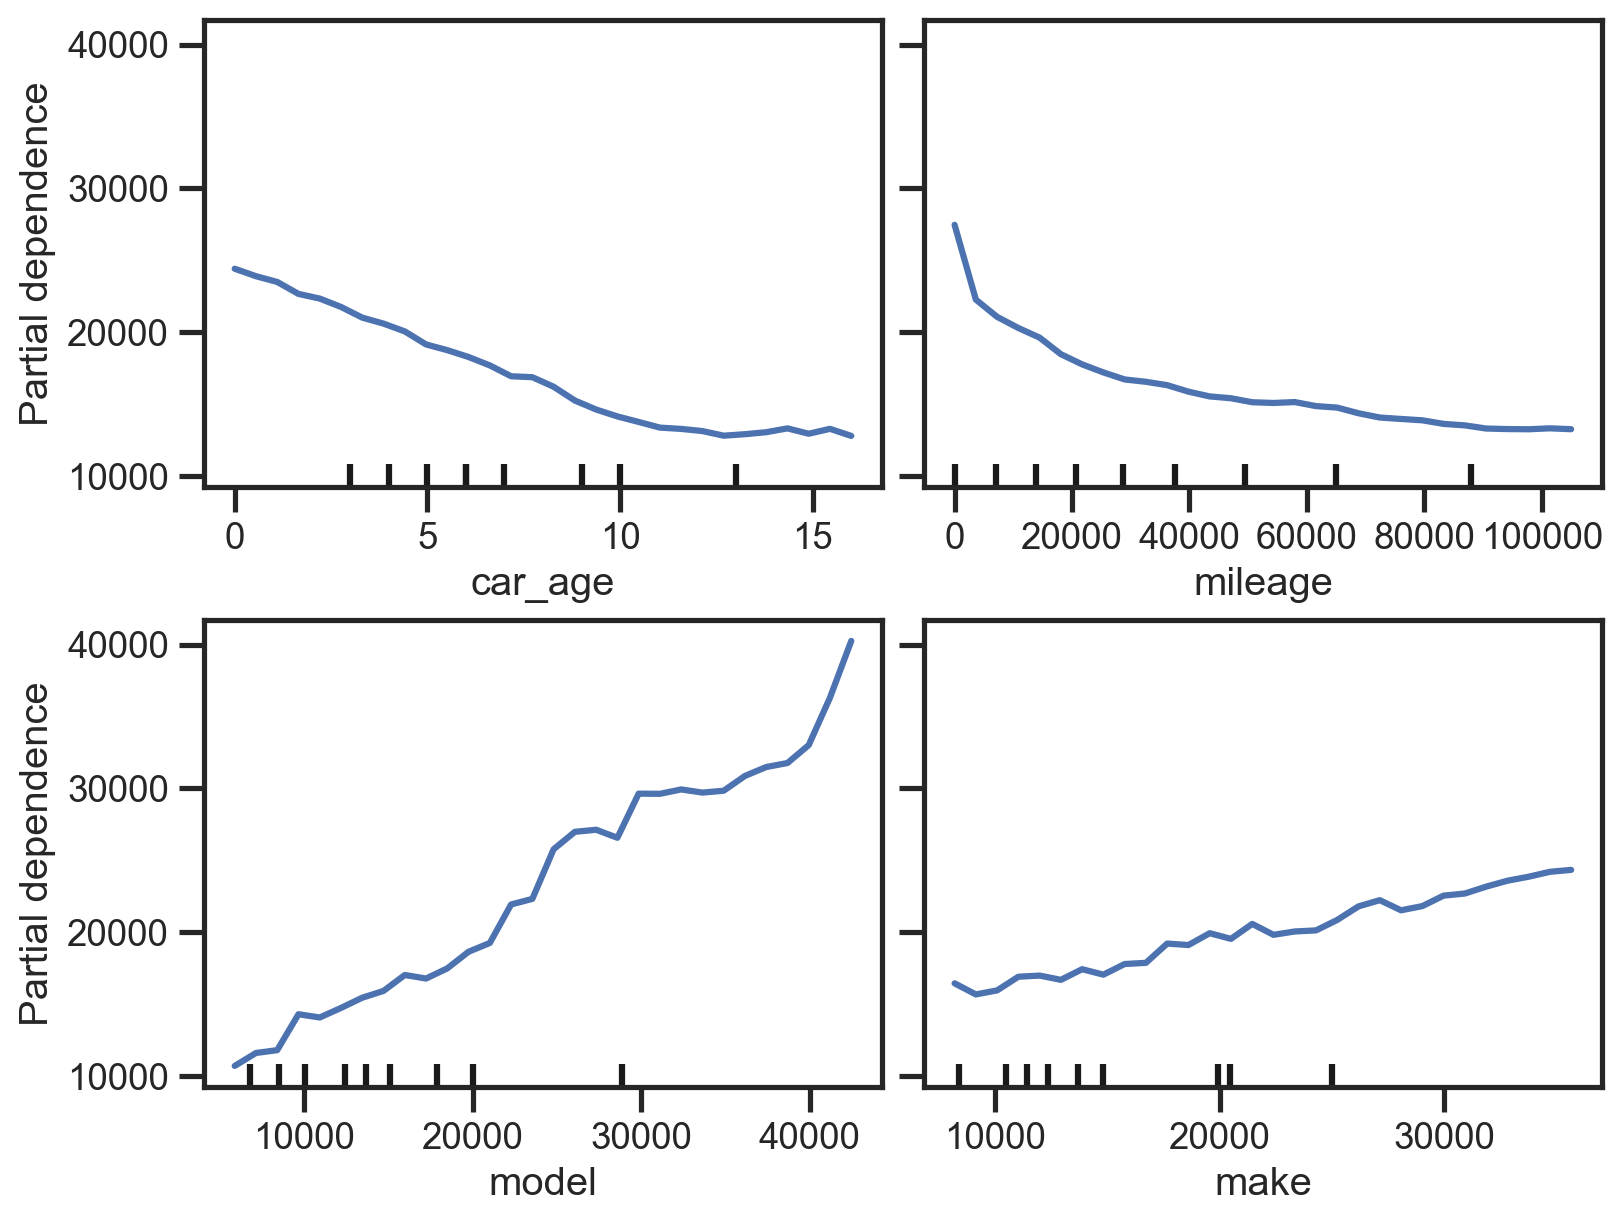

In [101]:
fig, ax = plt.subplots(figsize=(8,6), constrained_layout=True)
PartialDependenceDisplay.from_estimator(
    gb_regr_pipe, X_test, features=['car_age', 'mileage', 'model', 'make'],
    kind='average', 
    subsample=100, grid_resolution=30, n_jobs=2, random_state=0,
    ax=ax, n_cols=2
);

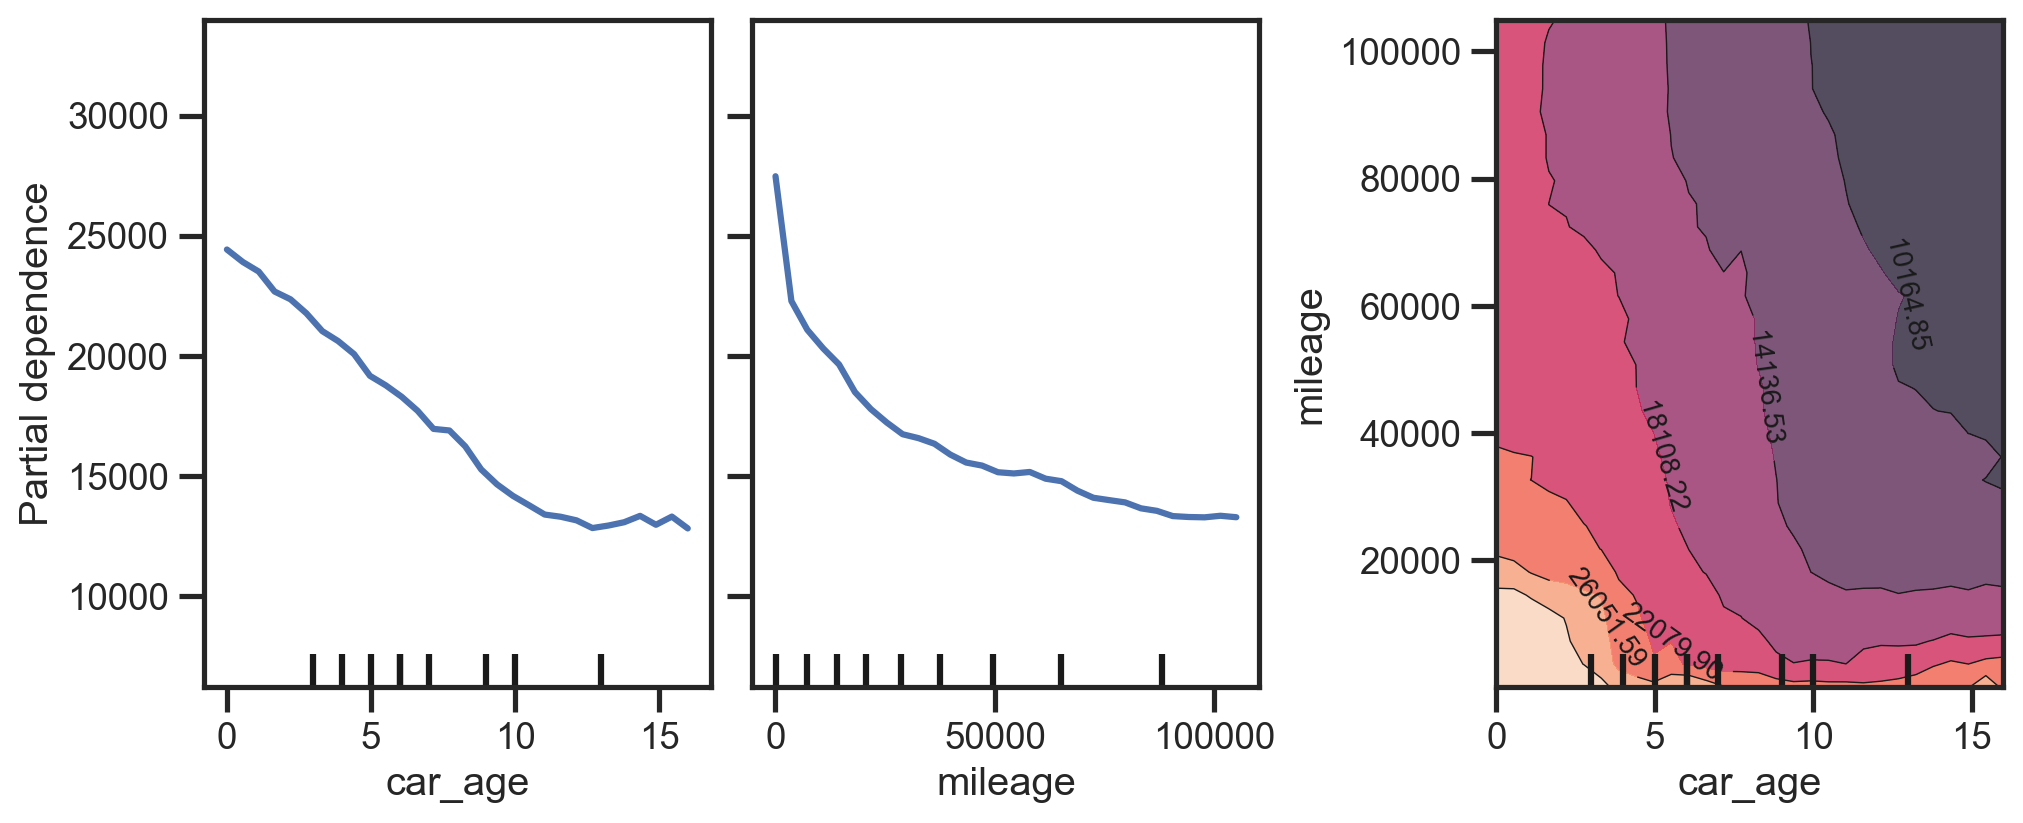

In [102]:
fig, ax = plt.subplots(figsize=(10,4), constrained_layout=True)
PartialDependenceDisplay.from_estimator(
    gb_regr_pipe, X_test, 
    features=["car_age", "mileage", ("car_age", "mileage")],
    kind='average', 
    ax=ax, n_cols=3,
    subsample=50, grid_resolution=30, n_jobs=2, random_state=0,
);